# Spark Pipeline with Kaggle Data

### 1. Set Up the Data

In [70]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st

# Creating a spark session
spark = SparkSession.builder.master('local').getOrCreate()
coffee_csv = './data/coffee.csv'
# All the columns should be floats except for the 'Date' and 'Currency' columns.
schema = 'date date,open float,high float,low float,close float,volume float,currency string'
# Read the coffee data CSV file into a Spark DataFrame.
df = spark.read.csv(coffee_csv, schema=schema, header=True, enforceSchema=True)
df.describe

<bound method DataFrame.describe of DataFrame[date: date, open: float, high: float, low: float, close: float, volume: float, currency: string]>

### Columns from Aggregate Functions

In [71]:
# Add a column to the DataFrame where the values are the difference between 'Open' and 'Close'.
df = df.withColumn('daily_price_change', sf.round(df.open - df.close))
# Add a column to the DataFrame where the values are the difference between 'High' and 'Low'.
df = df.withColumn('daily_fluctuation', sf.round(df.high - df.low))
# Add a column to the DataFrame where the values are 'True' if the volume for that day was 100 or above, and otherwise 'False'.
df = df.withColumn('vol_over_100', df.volume > 100)

df.show(3)
df.columns

+----------+------+-----+------+------+------+--------+------------------+-----------------+------------+
|      date|  open| high|   low| close|volume|currency|daily_price_change|daily_fluctuation|vol_over_100|
+----------+------+-----+------+------+------+--------+------------------+-----------------+------------+
|2000-01-03|122.25|124.0| 116.1| 116.5|6640.0|     USD|               6.0|              8.0|        true|
|2000-01-04|116.25|120.5|115.75|116.25|5492.0|     USD|               0.0|              5.0|        true|
|2000-01-05| 115.0|121.0| 115.0| 118.6|6165.0|     USD|              -4.0|              6.0|        true|
+----------+------+-----+------+------+------+--------+------------------+-----------------+------------+
only showing top 3 rows



['date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'currency',
 'daily_price_change',
 'daily_fluctuation',
 'vol_over_100']

In [80]:
# add a column that contains the absolute values of the numbers in the daily_price_change column
df = df.withColumn('daily_price_swing', sf.abs(df.daily_price_change))

# Compute a column called net_sales which is the average of opening, high, low, and closing cost times the volume: net_sales = avg(opening, high, low, closing price) * volume
#   Create a new df for the net_sales
net_sales_df = df.groupBy('date','volume').agg(sf.round(df.volume*(sf.mean(df.open + df.high + df.low + df.close))).alias('net_sales'))
# Join new dataframe onto main dataframe
df = df.join(net_sales_df, on=['date','volume'])

### Stats

In [63]:
# Find the average of the values in the column that has the absolute values of the difference between 'Open' and 'Close'.
df.select(sf.round(sf.mean('daily_price_swing'))).show()

+--------------------------------+
|round(avg(daily_price_swing), 0)|
+--------------------------------+
|                             2.0|
+--------------------------------+



In [66]:
# Get the count of values where the 'Volume' was less than 100.
# df.select('vol_over_100').where(df.vol_over_100 == False).count()
df.where(df.vol_over_100 == False).count()

1644

In [62]:
# Find the average 'Open' value.
df.select(sf.round(sf.mean('open'))).show()

+-------------------+
|round(avg(open), 0)|
+-------------------+
|              126.0|
+-------------------+



In [65]:
# Get the highest 'High' value.
df.select(sf.max('high')).show()

+---------+
|max(high)|
+---------+
|   306.25|
+---------+



### Write File

In [81]:
# Write the code to save the DataFrame with the four new columns created above as a Parquet file in the /data directory
df.write.parquet("./data/coffee_parquet", mode='overwrite')


## Bonus Questions:

In [82]:
import pandas as pd

# First convert to pandas dataframe, easier intergration with matplotlib
pdf = df.toPandas()


(5674, 12)

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

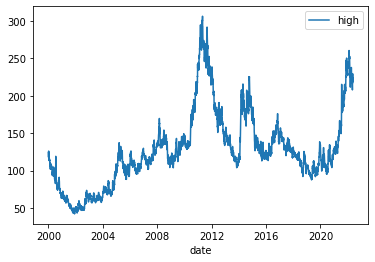

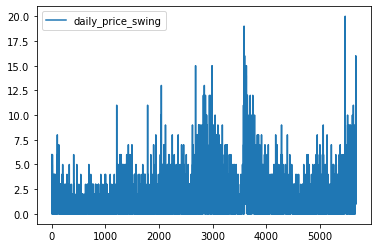

In [96]:
import matplotlib.pyplot as plt

plt.figure()
pdf.plot(x='date', y='high')
pdf.plot(y='daily_price_swing')